# [Phase 6] Deep Dive Simulation Analysis

**Economic, Demographic, and Governance Evaluation**

This notebook analyzes the outputs from the Agent-Based Model (ABM) to understand how resource availability, price fluctuations, and government intervention impact agent survival and wealth distribution.

---

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

MODEL_DATA_PATH = "../../data/output/phase6.1/model_data_test.csv"
AGENT_DATA_PATH = "../../data/output/phase6.1/agent_data_test.csv"

try:
    model_df = pd.read_csv(MODEL_DATA_PATH, index_col=0)
    agent_df = pd.read_csv(AGENT_DATA_PATH, index_col=0)
    print(f"Successfully loaded Model Data (shape: {model_df.shape}) and Agent Data (shape: {agent_df.shape}).")

except FileNotFoundError:
    print(f"Error: Data files not found")

Successfully loaded Model Data (shape: (50, 21)) and Agent Data (shape: (991, 12)).


## The Resource Economy: Supply vs Price

This section tracks the primary resource pools and how the dynamic pricing engine responds to supply levels.

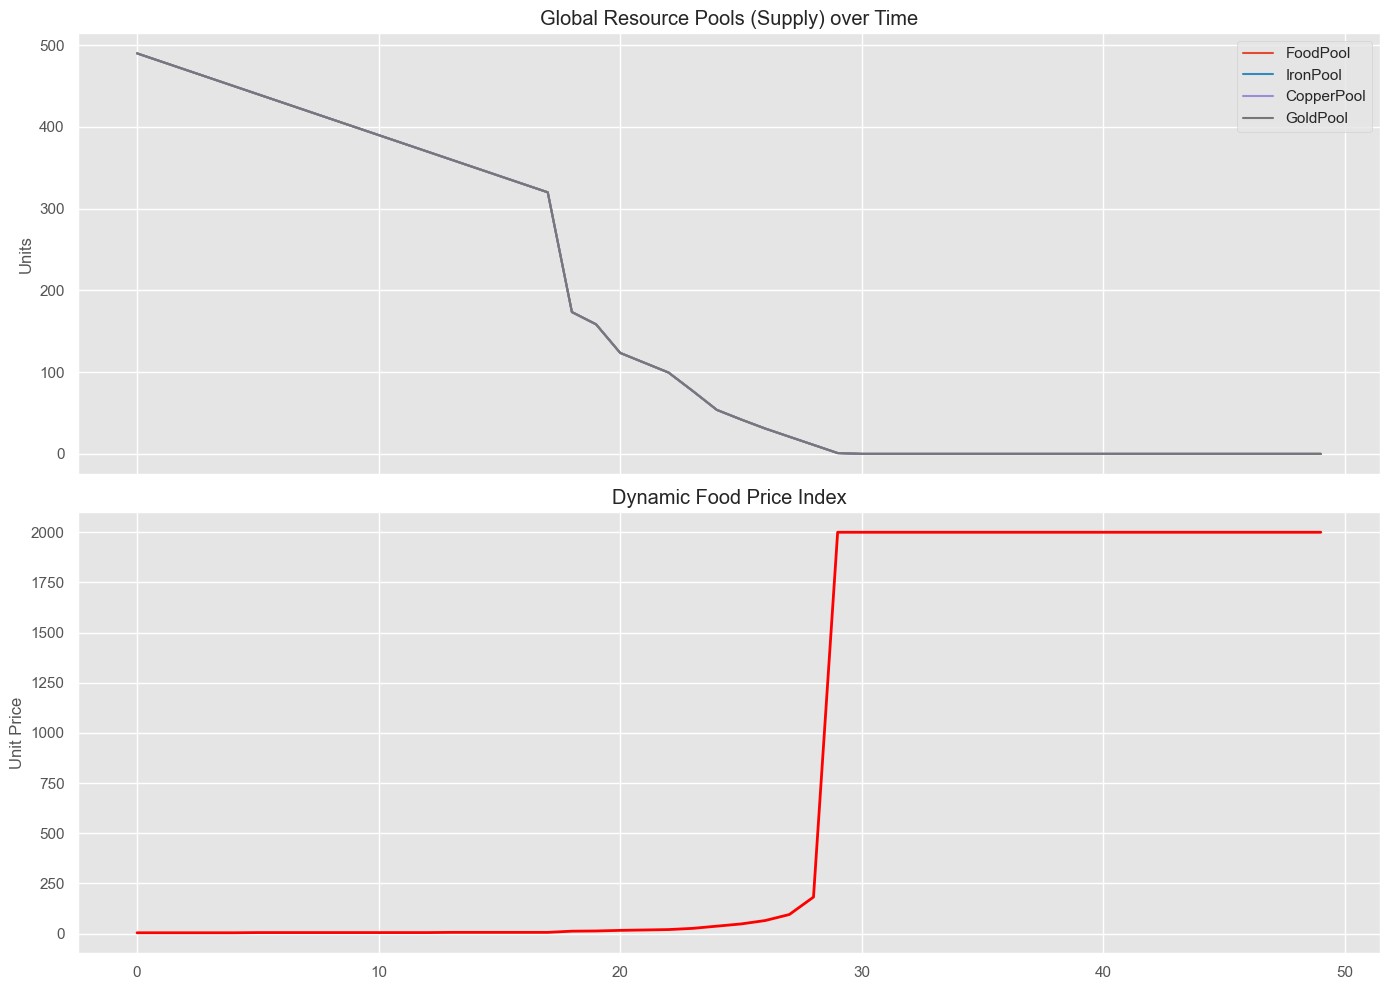

In [2]:
# 1.1 Resource Supply and Price Correlation
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

resource_cols = ['FoodPool', 'IronPool', 'CopperPool', 'GoldPool']
for col in resource_cols:
    if col in model_df.columns:
        axes[0].plot(model_df.index, model_df[col], label=col)
axes[0].set_title('Global Resource Pools (Supply) over Time')
axes[0].set_ylabel('Units')
axes[0].legend()
axes[0].grid(True)

if 'FoodPrice' in model_df.columns:
    axes[1].plot(model_df.index, model_df['FoodPrice'], color='red', linewidth=2)
    axes[1].set_title('Dynamic Food Price Index')
    axes[1].set_ylabel('Unit Price')
    axes[1].grid(True)

plt.tight_layout()
plt.show()

C:\Users\Kavishka\AppData\Local\Temp\ipykernel_18532\3441437872.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=model_df, x='CurrentSeason', palette='viridis')


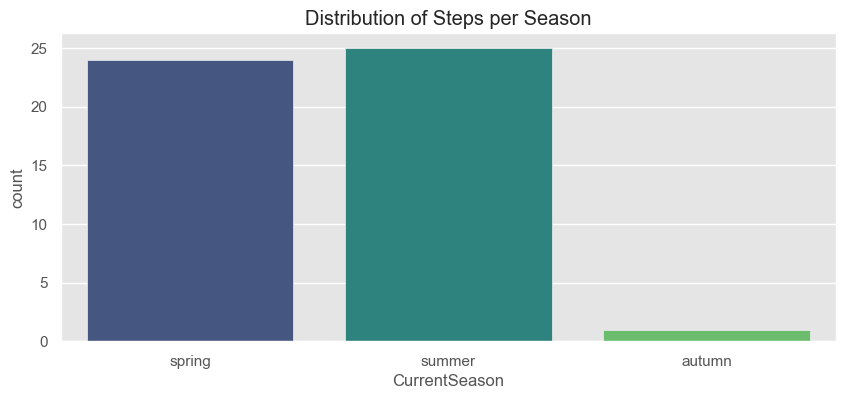

In [3]:
# 1.2 Seasonality Impact (using CurrentSeason reporter)
if 'CurrentSeason' in model_df.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=model_df, x='CurrentSeason', palette='viridis')
    plt.title('Distribution of Steps per Season')
    plt.show()

## City Demographics and Survival

We analyze the composition if the workforce (Farmers, Traders, Crafters) and the overall population health.

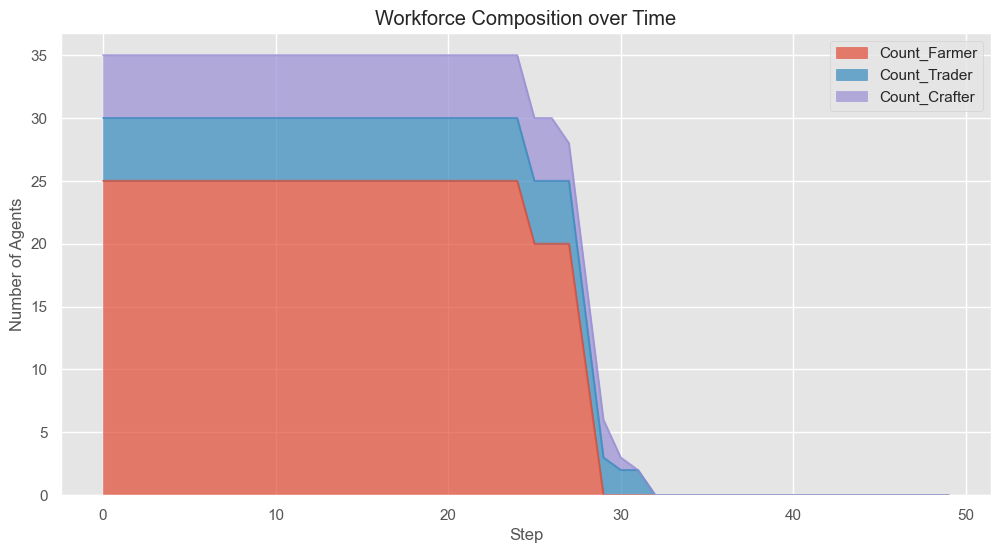

In [4]:
# 2.1 Agent Population Composition
agent_counts = ['Count_Farmer', 'Count_Trader', 'Count_Crafter']
plt.figure(figsize=(12,6))
model_df[agent_counts].plot(kind='area', stacked=True, alpha=0.7, ax=plt.gca())
plt.title('Workforce Composition over Time')
plt.xlabel('Step')
plt.ylabel('Number of Agents')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

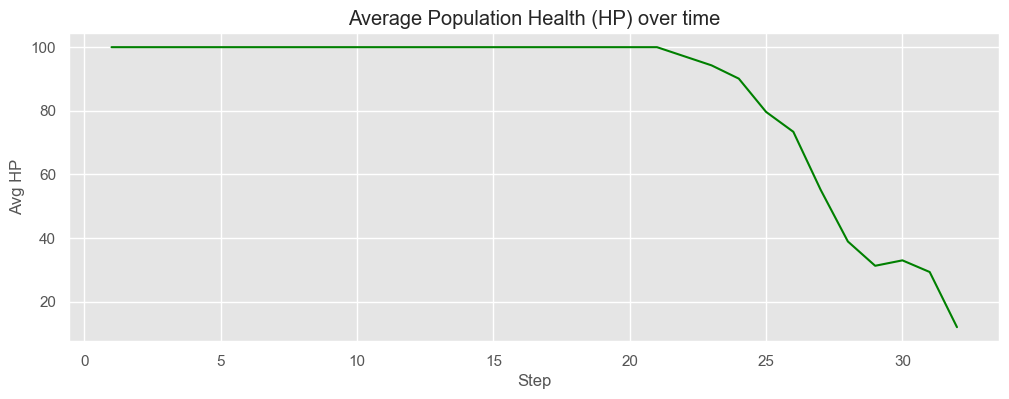

In [5]:
# 2.2 Global Health Status
if 'HealthPoints' in agent_df.columns:
    avg_hp_per_step = agent_df.groupby('Step')['HealthPoints'].mean()
    plt.figure(figsize=(12, 4))
    avg_hp_per_step.plot(color='green')
    plt.title('Average Population Health (HP) over time')
    plt.ylabel('Avg HP')
    plt.grid(True)
    plt.show()

## Governance and Fiscal Policy
The city has a governance layer that collects taxes and spends on public needs. This section visualizes the city's **Bank Account.**

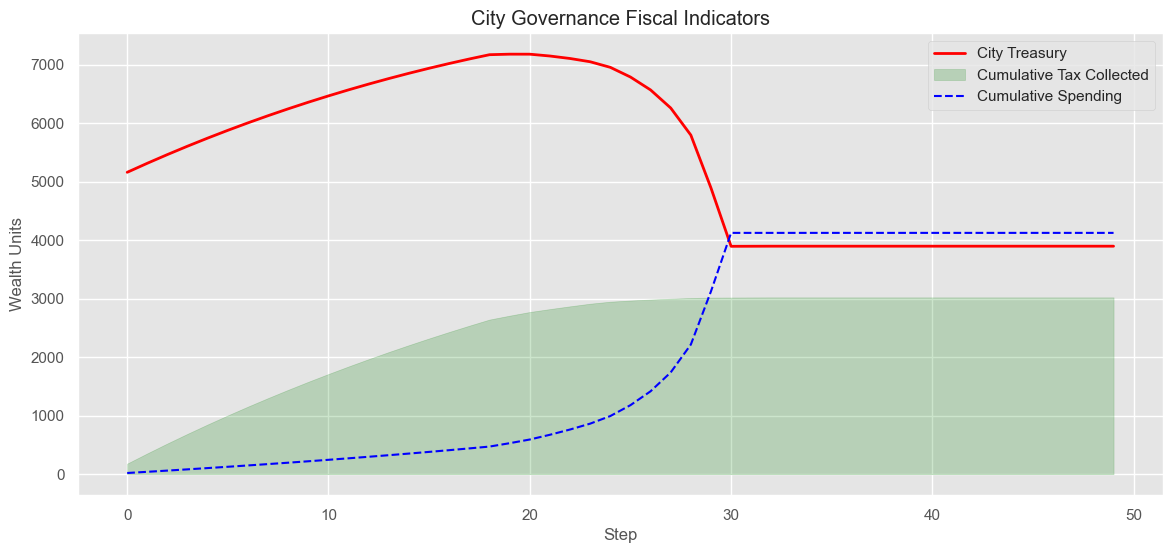

In [6]:
# 3.1 Fiscal Health: Treasury vs. Spending
plt.figure(figsize=(14, 6))
plt.plot(model_df.index, model_df['Treasury'], label='City Treasury', color='red', linewidth=2)
plt.fill_between(
    model_df.index, model_df['TotalTaxCollected'], label='Cumulative Tax Collected', color='green', alpha=0.2
)
plt.plot(
    model_df.index, model_df['TotalPublicSpending'], label='Cumulative Spending', color='blue', linestyle='--'
)
plt.title('City Governance Fiscal Indicators')
plt.xlabel('Step')
plt.ylabel('Wealth Units')
plt.legend()
plt.grid(True)
plt.show()

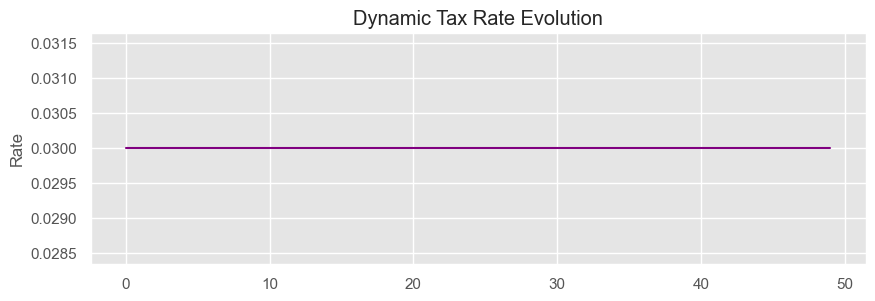

In [7]:
# 3.2 Tax Rate Dynamics
if 'TaxRate' in model_df.columns:
    plt.figure(figsize=(10, 3))
    plt.plot(model_df.index, model_df['TaxRate'], color='purple')
    plt.title('Dynamic Tax Rate Evolution')
    plt.ylabel('Rate')
    plt.show()

## Social Inequality: Wealth Distribution
Using the Gini Coefficient to track if wealth becomes concentrated in one class (e.g., Traders) or remains distributed.

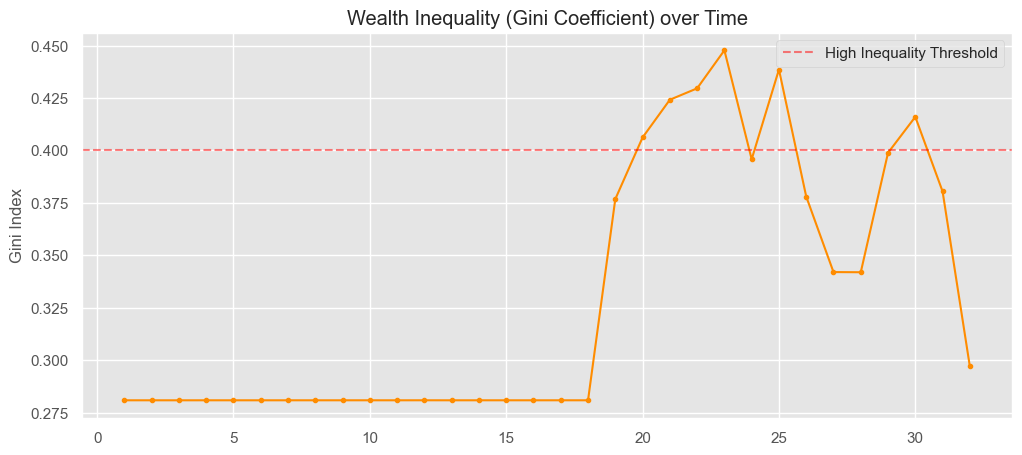

In [8]:
def calculate_gini(wealths):
    wealths = np.array(wealths)
    if wealths.sum() == 0: return 0.0
    wealths = np.sort(wealths)
    n = len(wealths)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * wealths)) / (n * np.sum(wealths))


# 4.1 Gini Coefficient Evolution
gini_history = agent_df.groupby('Step')['Wealth'].apply(calculate_gini)

plt.figure(figsize=(12, 5))
plt.plot(gini_history.index, gini_history.values, color='darkorange', marker='.')
plt.axhline(0.4, color='red', linestyle='--', alpha=0.5, label='High Inequality Threshold')
plt.title('Wealth Inequality (Gini Coefficient) over Time')
plt.ylabel('Gini Index')
plt.legend()
plt.grid(True)
plt.show()

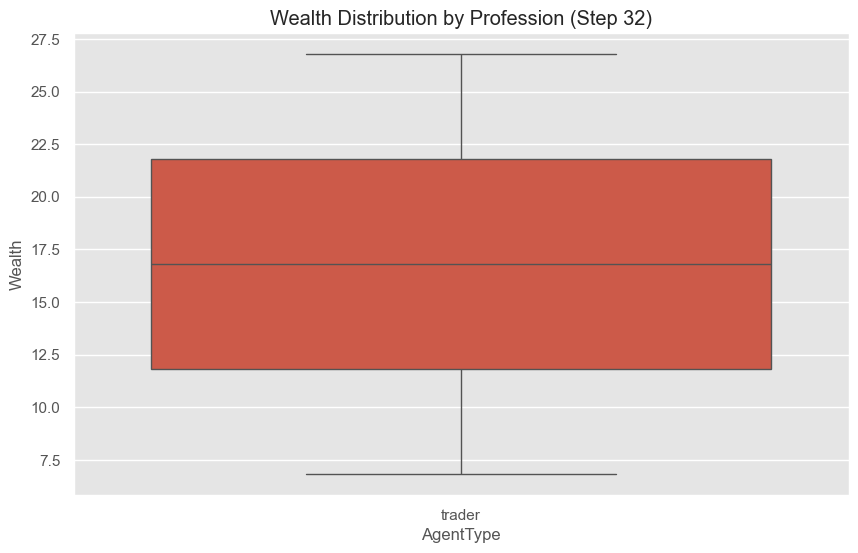

In [9]:
# 4.2 Wealth Distribution by Agent Type (Final Step)
final_step = agent_df['Step'].max()
plt.figure(figsize=(10, 6))
sns.boxplot(data=agent_df[agent_df['Step'] == final_step], x='AgentType', y='Wealth')
plt.title(f'Wealth Distribution by Profession (Step {final_step})')
plt.show()

## Micro-Level Analysis: Inventory and Supply
Exploring how individual agents manage their personal stocks of food.

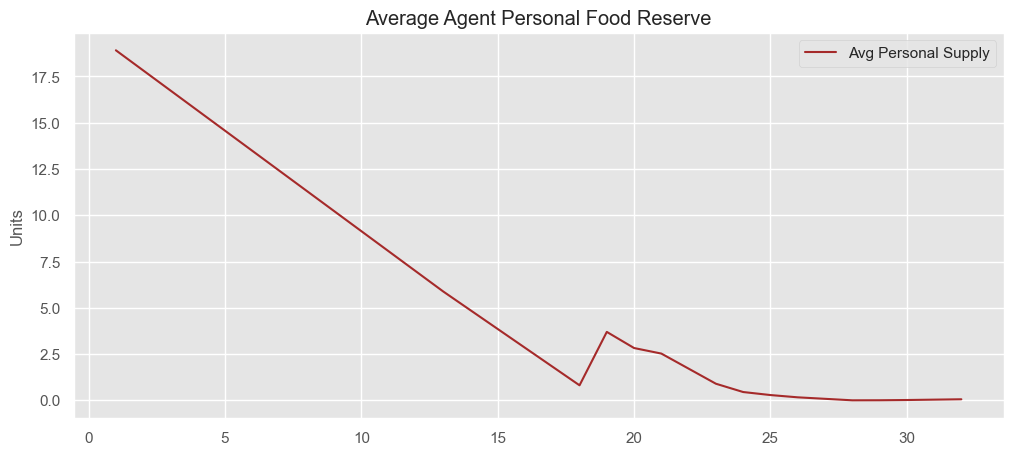

In [10]:
# 5.1 Personal Food Supply vs. Global Supply
plt.figure(figsize=(12, 5))
avg_personal_food = agent_df.groupby('Step')['PersonalFoodSupply'].mean()
plt.plot(avg_personal_food.index, avg_personal_food.values, label='Avg Personal Supply', color='brown')
plt.title('Average Agent Personal Food Reserve')
plt.ylabel('Units')
plt.legend()
plt.show()

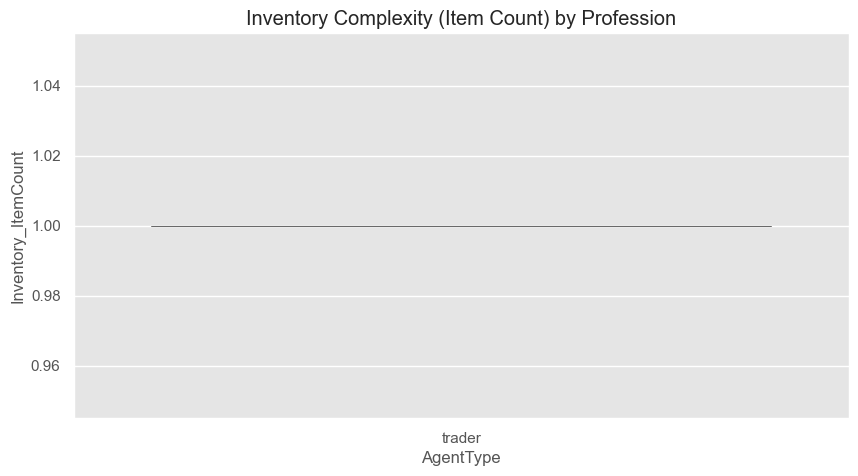

In [11]:
# 5.2 Inventory Complexity
# Analyzing the number of items agents carry
plt.figure(figsize=(10, 5))
sns.violinplot(data=agent_df[agent_df['Step'] == final_step], x='AgentType', y='Inventory_ItemCount')
plt.title('Inventory Complexity (Item Count) by Profession')
plt.show()

## Final Simulation Performance Summary
A snapshot of the city’s health at the end of the run.

In [12]:
final_metrics = {
    "Final Population": model_df['TotalAgents'].iloc[-1],
    "Survival Rate (%)": (model_df['TotalAgents'].iloc[-1] / model_df['TotalAgents'].iloc[0]) * 100,
    "Final Treasury": model_df['Treasury'].iloc[-1],
    "Final Gini Index": gini_history.iloc[-1],
    "Total Public Spending": model_df['TotalPublicSpending'].iloc[-1]
}

summary_df = pd.DataFrame(list(final_metrics.items()), columns=['Metric', 'Value'])
print("--- End of Phase 6: City Performance Summary ---")
print(summary_df.to_string(index=False))

--- End of Phase 6: City Performance Summary ---
               Metric       Value
     Final Population    0.000000
    Survival Rate (%)    0.000000
       Final Treasury 3897.380000
     Final Gini Index    0.297024
Total Public Spending 4124.940000
